In [1]:
import random
from sklearn import linear_model
from matplotlib import pyplot as plt
from collections import defaultdict
import gzip
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import json
import numpy
import dateutil.parser
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.optimize
from sklearn import svm
import string
import random

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.als import AlternatingLeastSquares
import numpy as np
import os
import tarfile

## MovieLens Data

In [2]:
# Update the file paths based on your extraction path
extract_path = "ml-1m/ml-1m"

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Users File
users_file = os.path.join(extract_path, "users.dat")
users_columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users_df = pd.read_csv(users_file, sep="::", engine="python", header=None, names=users_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

In [3]:
# Check for null values in Ratings file

# None of the columns contain null values
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

Text(0, 0.5, 'Count')

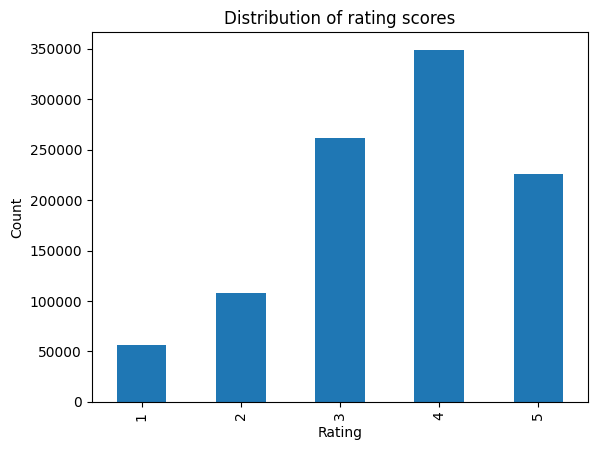

In [4]:
# Plot distribution of rating scores
ratings_df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating scores')
plt.ylabel('Count')

# There do not appear to be any placeholders for missing vals
# Most ratings are 4 stars, the least amount of ratings are 1 star

Text(0, 0.5, 'Count')

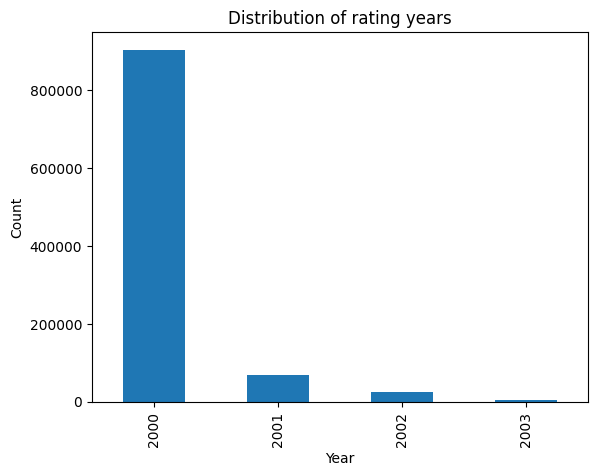

In [5]:
# Convert Timestamp col to datetime objects for visualizations
datetime = pd.to_datetime(ratings_df['Timestamp'], unit='s')

# Plot year of rating
datetime.dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating years')
plt.xlabel('Year')
plt.ylabel('Count')

# ALmost all ratings are from 2000

Text(0, 0.5, 'Count')

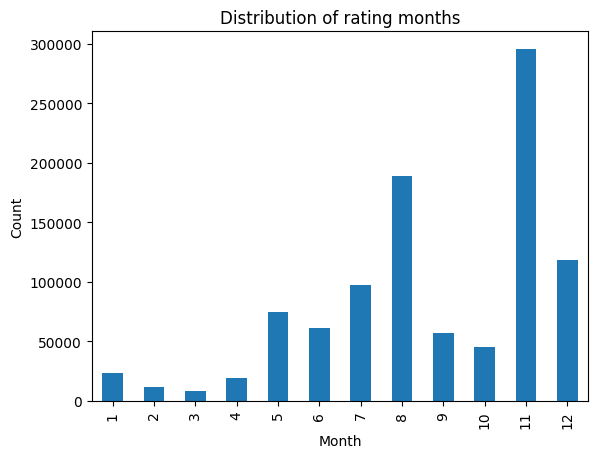

In [6]:
# Plot months of rating
datetime.dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating months')
plt.xlabel('Month')
plt.ylabel('Count')

# Most ratings are from November

Text(0, 0.5, 'Count')

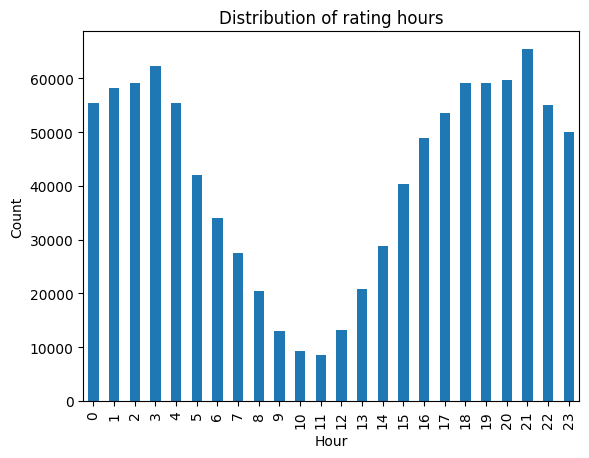

In [7]:
# Plot hour of rating
datetime.dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating hours')
plt.xlabel('Hour')
plt.ylabel('Count')

# Most ratings happen at the beginning of the day or the end, as that's where peaks happen.

In [8]:
# There do not appear to be any placeholders for null values
ratings_df['UserID'].min(), ratings_df['UserID'].max()

(1, 6040)

In [9]:
# Top 5 user IDs who left the most ratings
ratings_df['UserID'].value_counts()[:5]

UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: count, dtype: int64

In [10]:
# There do not appear to be any placeholders for null values
ratings_df['MovieID'].min(), ratings_df['MovieID'].max()

(1, 3952)

In [11]:
# Top 5 movie IDs with the most ratings
ratings_df['MovieID'].value_counts()[:5]

MovieID
2858    3428
260     2991
1196    2990
1210    2883
480     2672
Name: count, dtype: int64

## Last.FM (LFM360K) Data

In [12]:
tar_path = "lastfm-dataset-360K.tar.gz"
extract_path_lastfm = "lastfm-dataset-360K/lastfm-dataset-360K"

with tarfile.open(tar_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extract_path_lastfm)

In [13]:
# Users-Artists-Plays File
users_artists_plays_file = os.path.join(extract_path_lastfm, "usersha1-artmbid-artname-plays.tsv")
users_artists_plays_columns = ["user-mboxsha1", "musicbrainz-artist-id", "artist-name", "plays"]
users_artists_plays_df = pd.read_csv(users_artists_plays_file, sep="\t", header=None, names=users_artists_plays_columns)

# Users Profile File
users_profile_file = os.path.join(extract_path_lastfm, "usersha1-profile.tsv")
users_profile_columns = ["user-mboxsha1", "gender", "age", "country", "signup"]
users_profile_df = pd.read_csv(users_profile_file, sep="\t", header=None, names=users_profile_columns)

In [14]:
# Check for null values in Users-Artists-Plays file
users_artists_plays_df.isnull().sum()

user-mboxsha1                 0
musicbrainz-artist-id    226137
artist-name                 204
plays                         0
dtype: int64

In [15]:
# TO-DO: how to fill in nulls for artist-id & artist-name? Backfill?

In [16]:
# Check for null values in Users Profile file

# Gender & age columns contain null values
users_profile_df.isnull().sum()

user-mboxsha1        0
gender           32775
age              74900
country              0
signup               0
dtype: int64

In [17]:
# Fill missing gender with backfill
users_profile_df = users_profile_df.bfill()

Text(0.5, 0, 'Count')

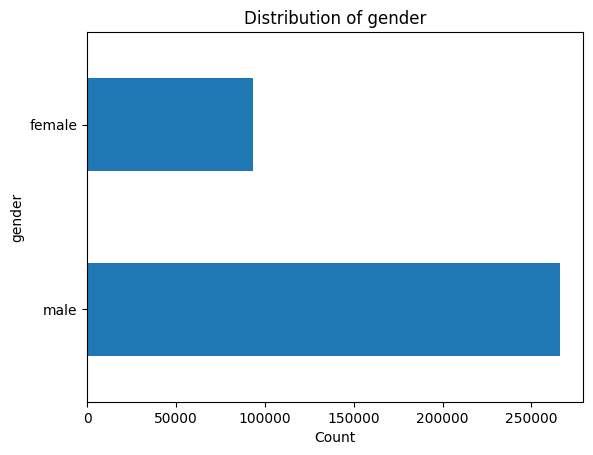

In [18]:
# Plot gender distribution of users
users_profile_df['gender'].value_counts().plot(kind='barh')
plt.title('Distribution of gender')
plt.yticks(ticks=[0,1], labels=["male", "female"])
plt.xlabel('Count')

# Most users are male

In [19]:
# Summary stats for Age col
# Min and max show that there are errors in data since ages of -1337 and 1002 are impossible
users_profile_df['age'].describe()

count    359347.000000
mean         25.075387
std          22.708784
min       -1337.000000
25%          20.000000
50%          23.000000
75%          28.000000
max        1002.000000
Name: age, dtype: float64

In [20]:
# Change age to null in rows where age is entered incorrectly (negative or over 100)
users_profile_df.loc[(users_profile_df['age'] < 0) | (users_profile_df['age'] > 100), ['age']] = np.nan

users_profile_df['age'].describe()

count    357870.000000
mean         25.059424
std           8.234709
min           1.000000
25%          20.000000
50%          23.000000
75%          28.000000
max         100.000000
Name: age, dtype: float64

In [21]:
# Fill missing age with age (in years) closest to mean age
users_profile_df['age'] = users_profile_df['age'].fillna(np.round(users_profile_df['age'].mean()))

Text(0, 0.5, 'Count')

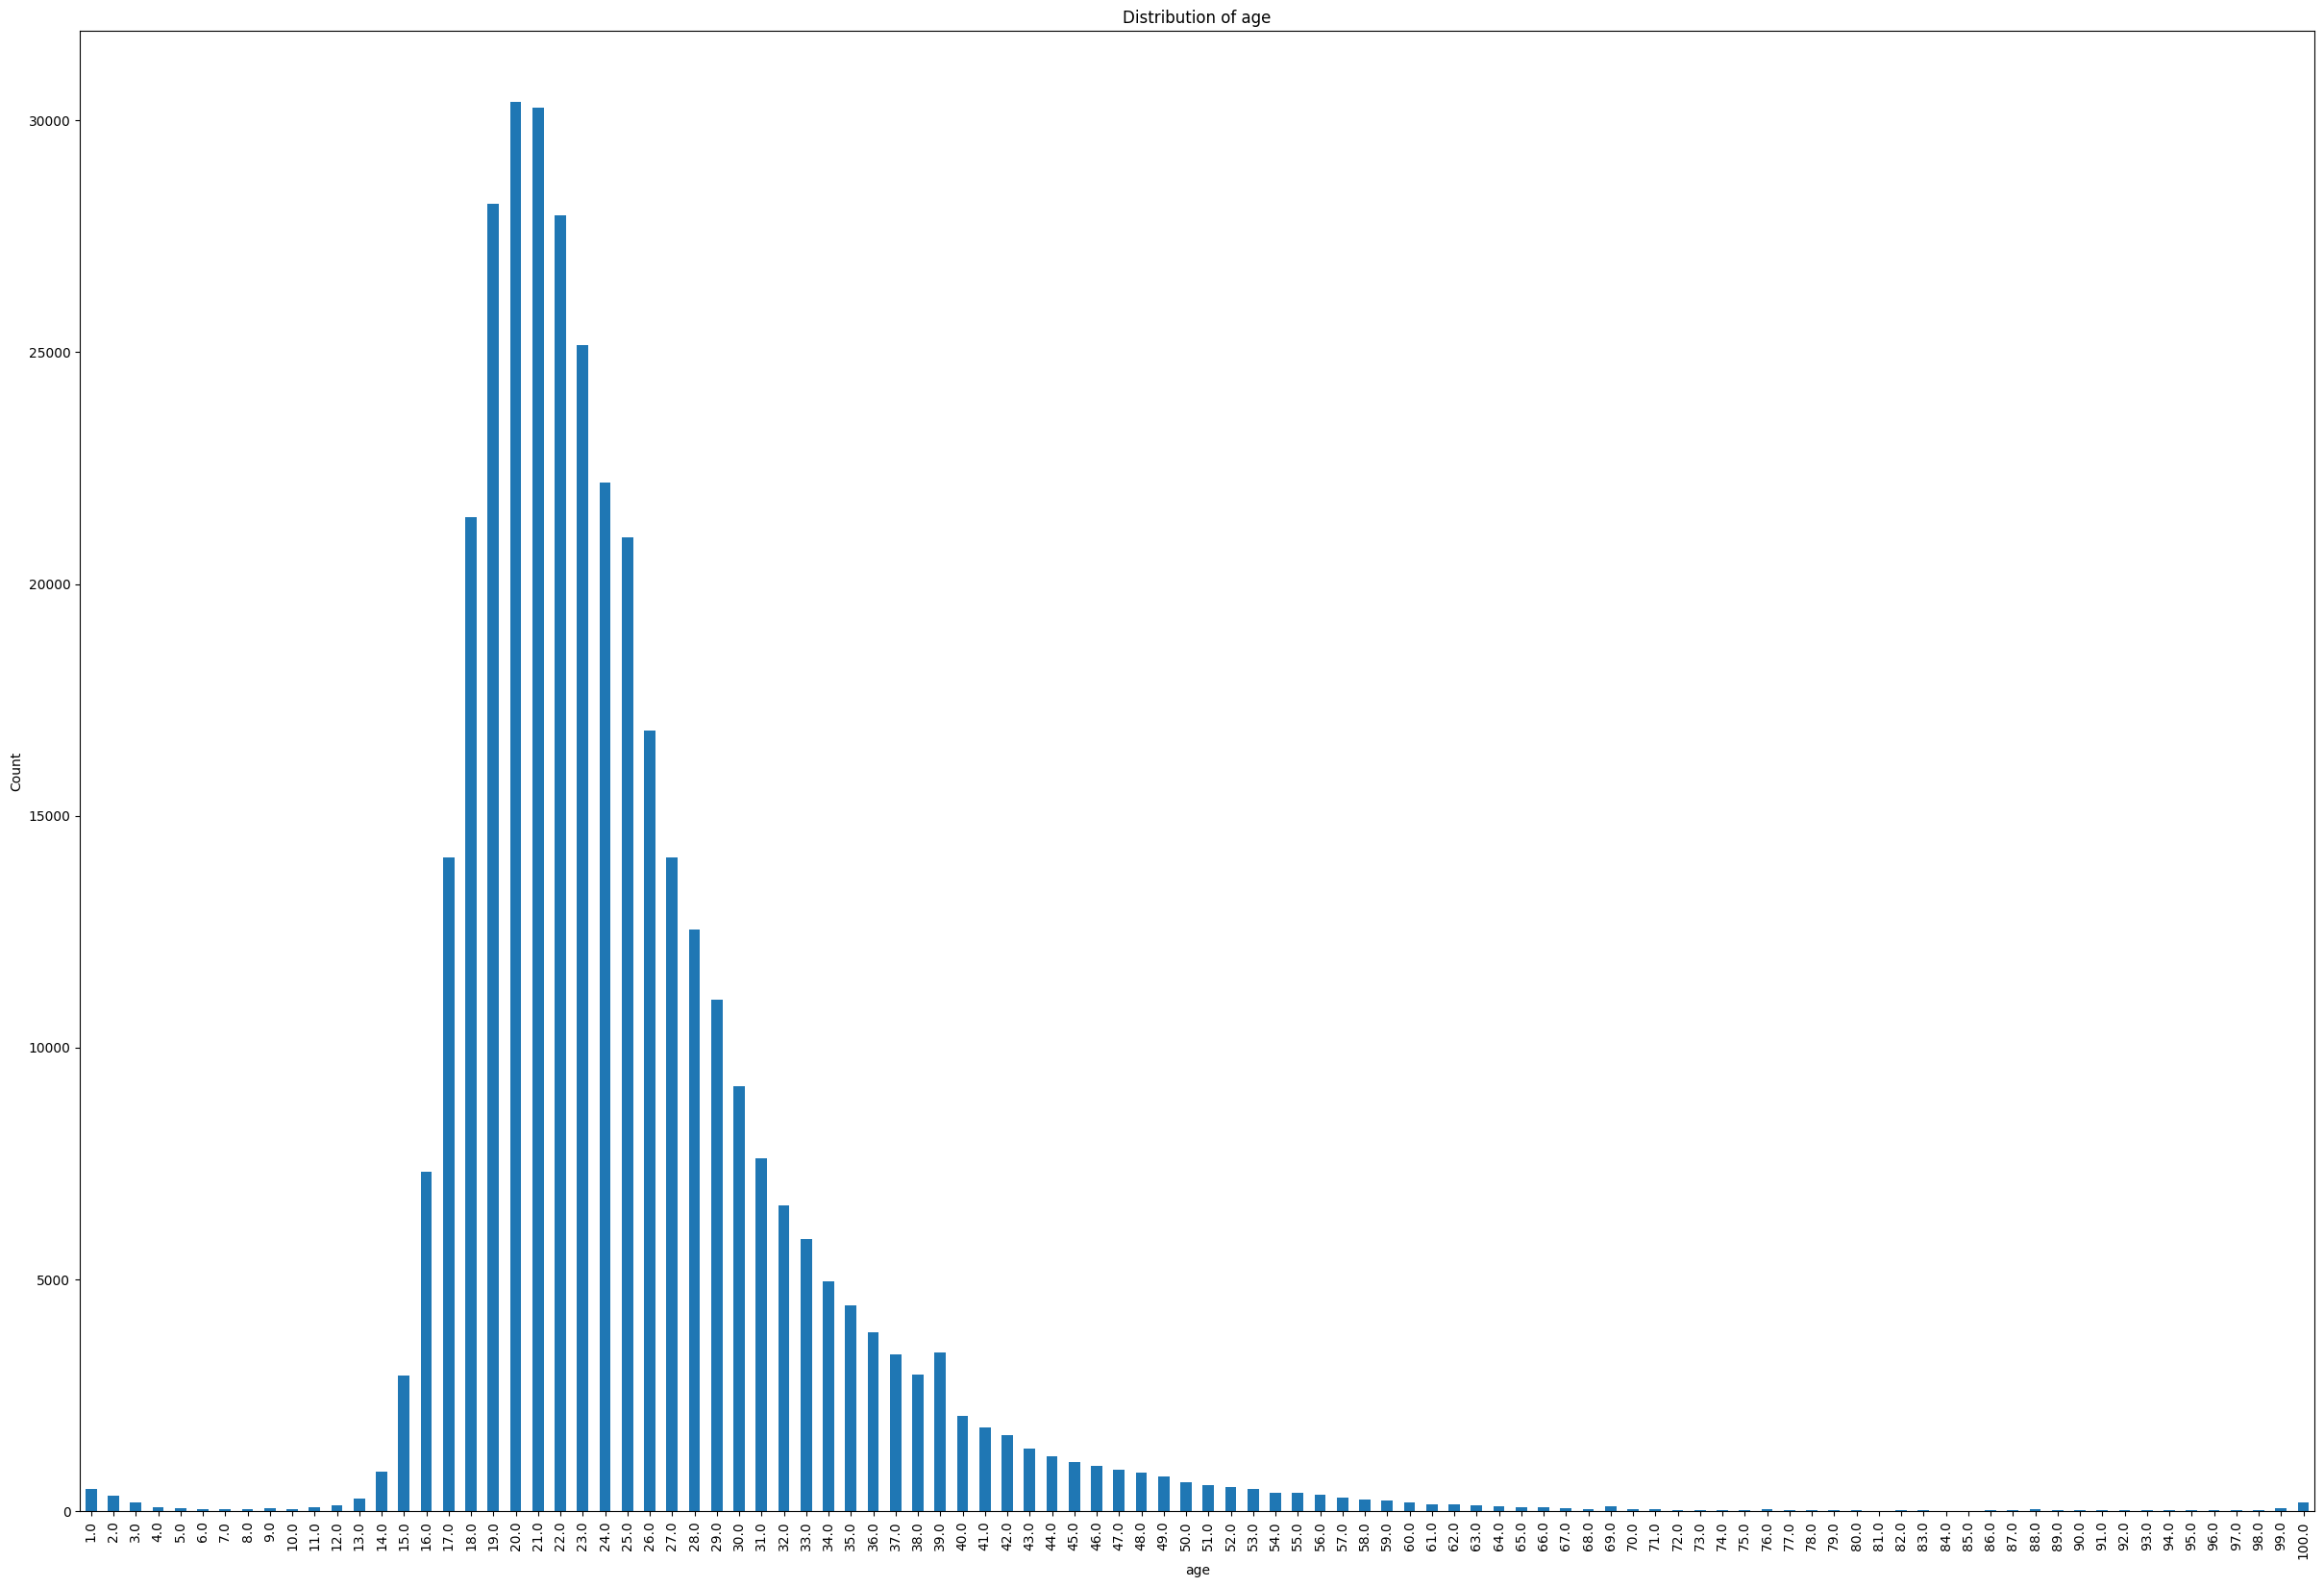

In [22]:
# Plot age of users
users_profile_df['age'].value_counts().sort_index().plot(kind='bar', figsize=(30,20))
plt.title('Distribution of age')
plt.ylabel('Count')

# Right skewed distribution, most users between 18-25 years old

Text(0.5, 0, 'Count')

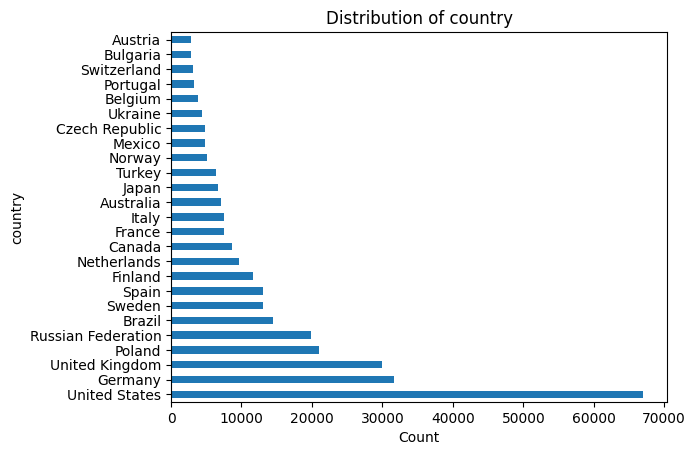

In [23]:
# Top 25 countries users are based in
users_profile_df['country'].value_counts()[:25].plot(kind='barh')
plt.title('Distribution of country')
plt.xlabel('Count')

# Most users from the U.S.

Text(0, 0.5, 'Count')

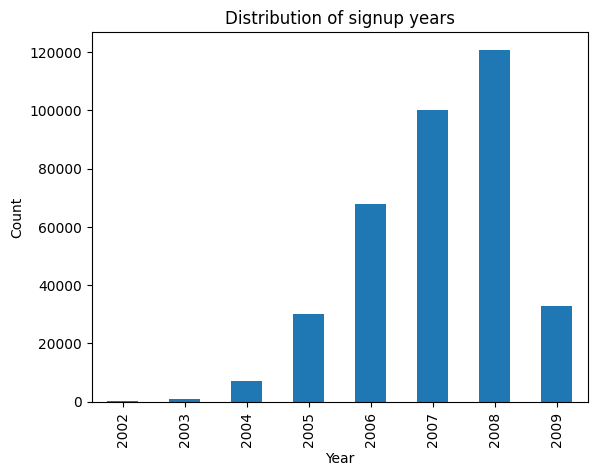

In [24]:
# Convert signup date col to datetime objects for visualizations
signup = pd.to_datetime(users_profile_df['signup'])

# Plot year of rating
signup.dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of signup years')
plt.xlabel('Year')
plt.ylabel('Count')

# Most users signed up in 2008

Text(0, 0.5, 'Count')

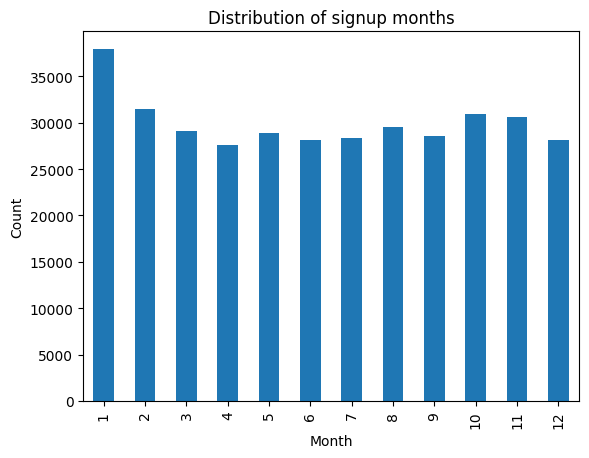

In [25]:
# Plot month of rating
signup.dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of signup months')
plt.xlabel('Month')
plt.ylabel('Count')

# Most users sign up in beginning of year (Jan) but mostly uniform distribution